In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Reference : https://www.kaggle.com/serigne/instacart-simple-data-exploration

In [2]:
products_df = pd.read_csv("../data/raw/products.csv")
aisles_df = pd.read_csv("../data/raw/aisles.csv")
departments_df = pd.read_csv("../data/raw/departments.csv")
orders_df = pd.read_csv("../data/raw/orders.csv")
op_train_df = pd.read_csv("../data/raw/order_products__train.csv")
op_prior_df = pd.read_csv("../data/raw/order_products__prior.csv") 

In [3]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
op_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
op_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
op_all_df = pd.concat([op_train_df, op_prior_df], axis=0)
print("The order_products_all size is : ", op_all_df.shape)

The order_products_all size is :  (33819106, 4)


## Missing values

In [18]:
orders_na = (orders_df.isnull().sum() / len(orders_df)) * 100
orders_na

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.027594
dtype: float64

In [10]:
total = op_all_df.isnull().sum().sort_values(ascending=False)
percent = (op_all_df.isnull().sum()/op_all_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


In [11]:
# Check the number of unique orders and unique products
orders_Unique = len(set(op_all_df.order_id))
products_Unique = len(set(op_all_df.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


### Number of products that people usually order

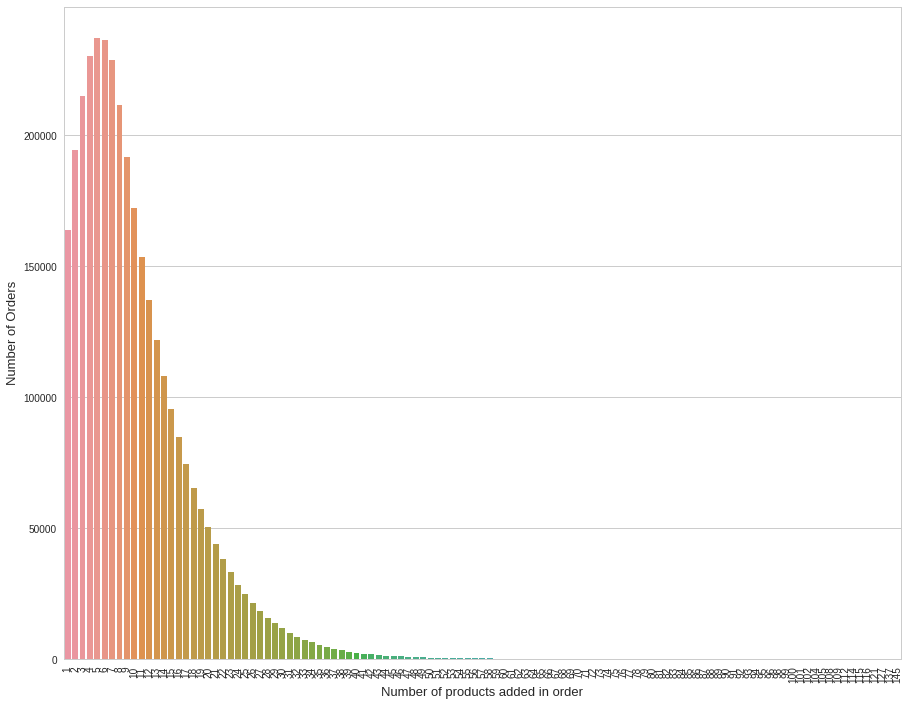

In [12]:
grouped = op_all_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

### Most ordered products

In [15]:
grouped = op_all_df.groupby("product_id")["reordered"].aggregate({'Total_orders': 'count'}).reset_index()
grouped = pd.merge(grouped, products_df[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_orders', ascending=False)[:10]
grouped

,product_id,Total_orders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


### Most re-ordered products

In [14]:
grouped = op_all_df.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'}).reset_index()
grouped = pd.merge(grouped, products_df[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,415166,Banana
13173,13176,329275,Bag of Organic Bananas
21134,21137,214448,Organic Strawberries
21900,21903,194939,Organic Baby Spinach
47205,47209,176173,Organic Hass Avocado
47762,47766,140270,Organic Avocado
27842,27845,118684,Organic Whole Milk
47622,47626,112178,Large Lemon
27963,27966,109688,Organic Raspberries
16794,16797,104588,Strawberries


In [16]:
grouped = op_all_df.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products_df[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


### Time at which people usually order products

#### Hours of Order in a Day

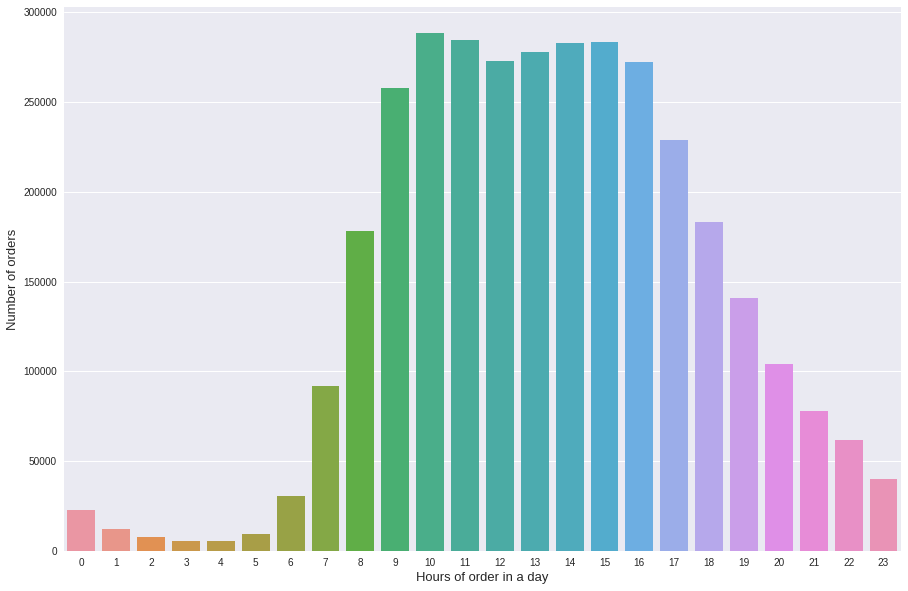

In [20]:
grouped = orders_df.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

#### Days of Orders in a week:

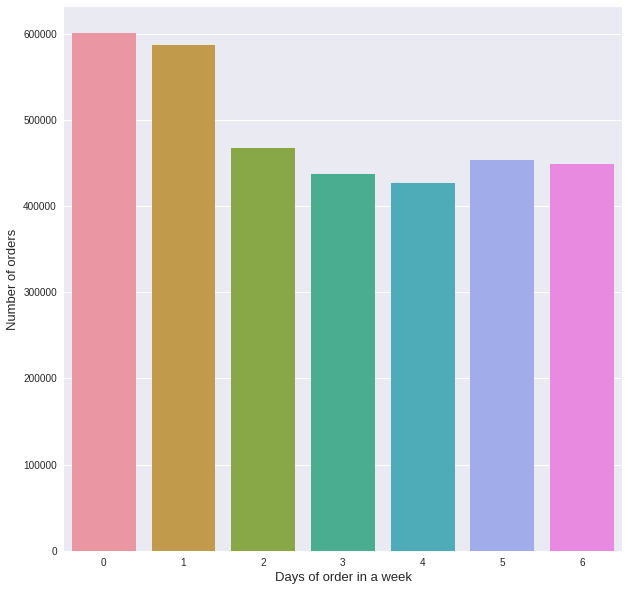

In [21]:
grouped = orders_df.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

#### Period of orders

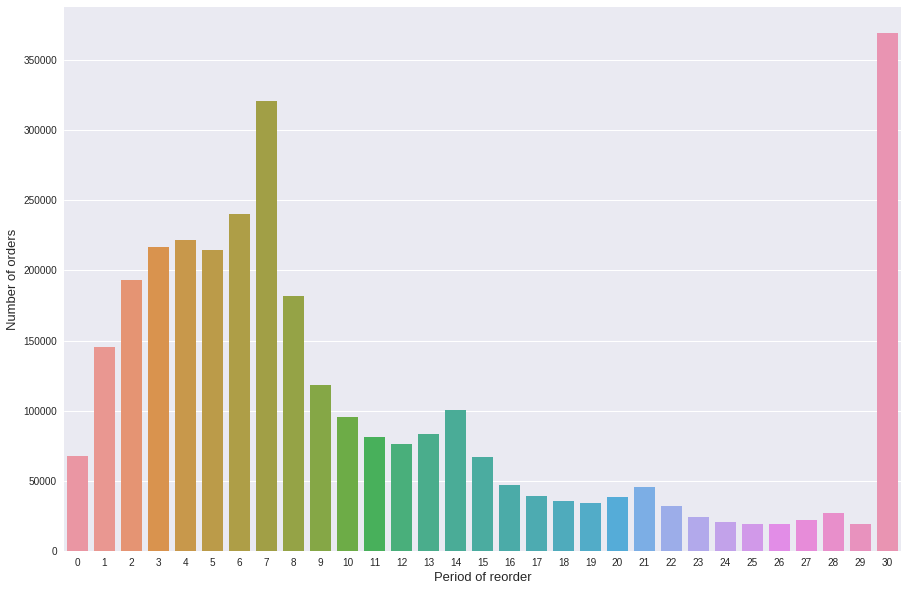

In [23]:
grouped = orders_df.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

### Number and ratio of orders from the three datasets (prior, train, test)

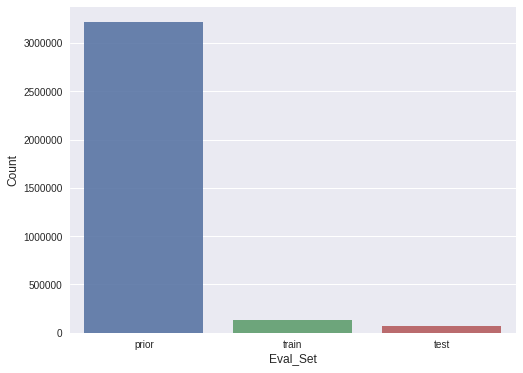

In [24]:
count_eval = orders_df.eval_set.value_counts()
#Plot it
plt.figure(figsize=(8,6))
sns.barplot(count_eval.index, count_eval.values, alpha = 0.9)
plt.xlabel('Eval_Set', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

###  Number of unique customers in the three datasets (prior, train, test)

In [25]:
print("Number of unique customers in the whole dataset : ",len(set(orders_df.user_id)))

Number of unique customers in the whole dataset :  206209


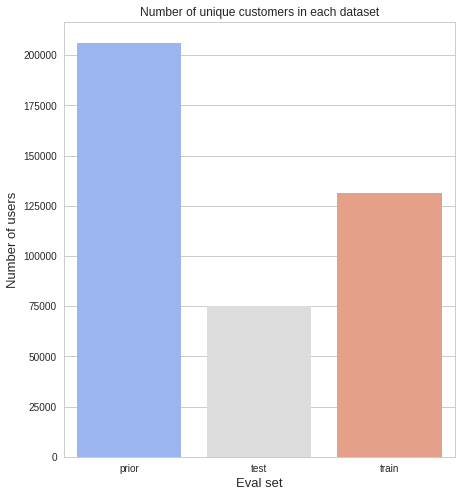

In [27]:
grouped = orders_df.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))

sns.set_style('whitegrid')
plt.figure(figsize=(7,8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()

### Orders made by each customer

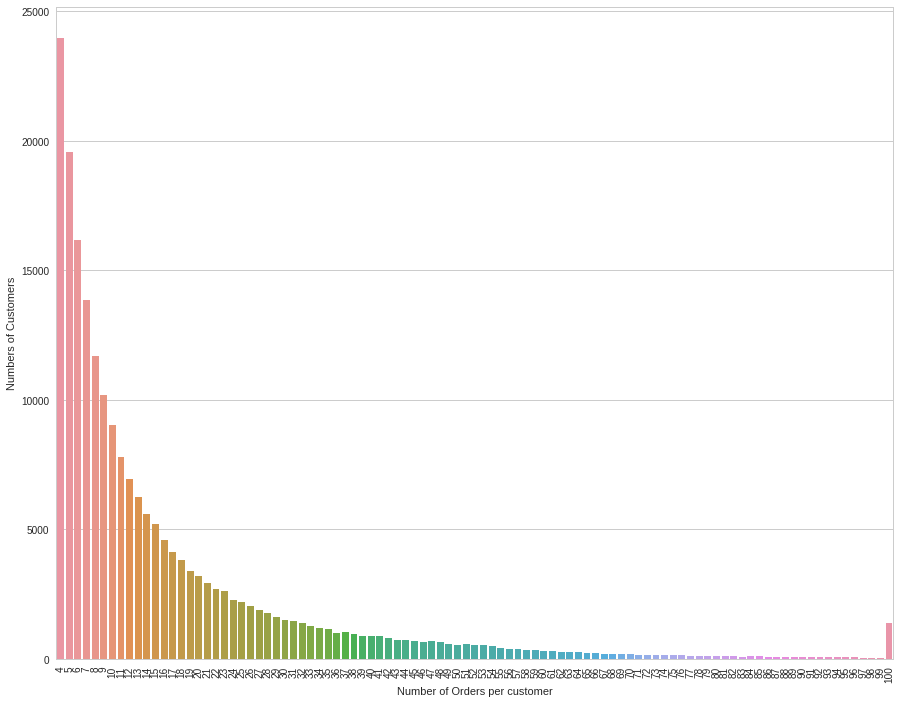

In [28]:
grouped = orders_df.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made 4 orders.

### Most important Departments (by number of products)

In [31]:
items  = pd.merge(left = pd.merge(left=products_df, right=departments_df, how='left'), right=aisles_df, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [32]:
grouped = items.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132084
20,snacks,6264,0.126067
16,pantry,5371,0.108095
3,beverages,4365,0.087848
10,frozen,4007,0.080643
7,dairy eggs,3449,0.069413
11,household,3085,0.062087
6,canned goods,2092,0.042103
9,dry goods pasta,1858,0.037393
19,produce,1684,0.033891


### Most important Aisles in each Department (by number of Products)

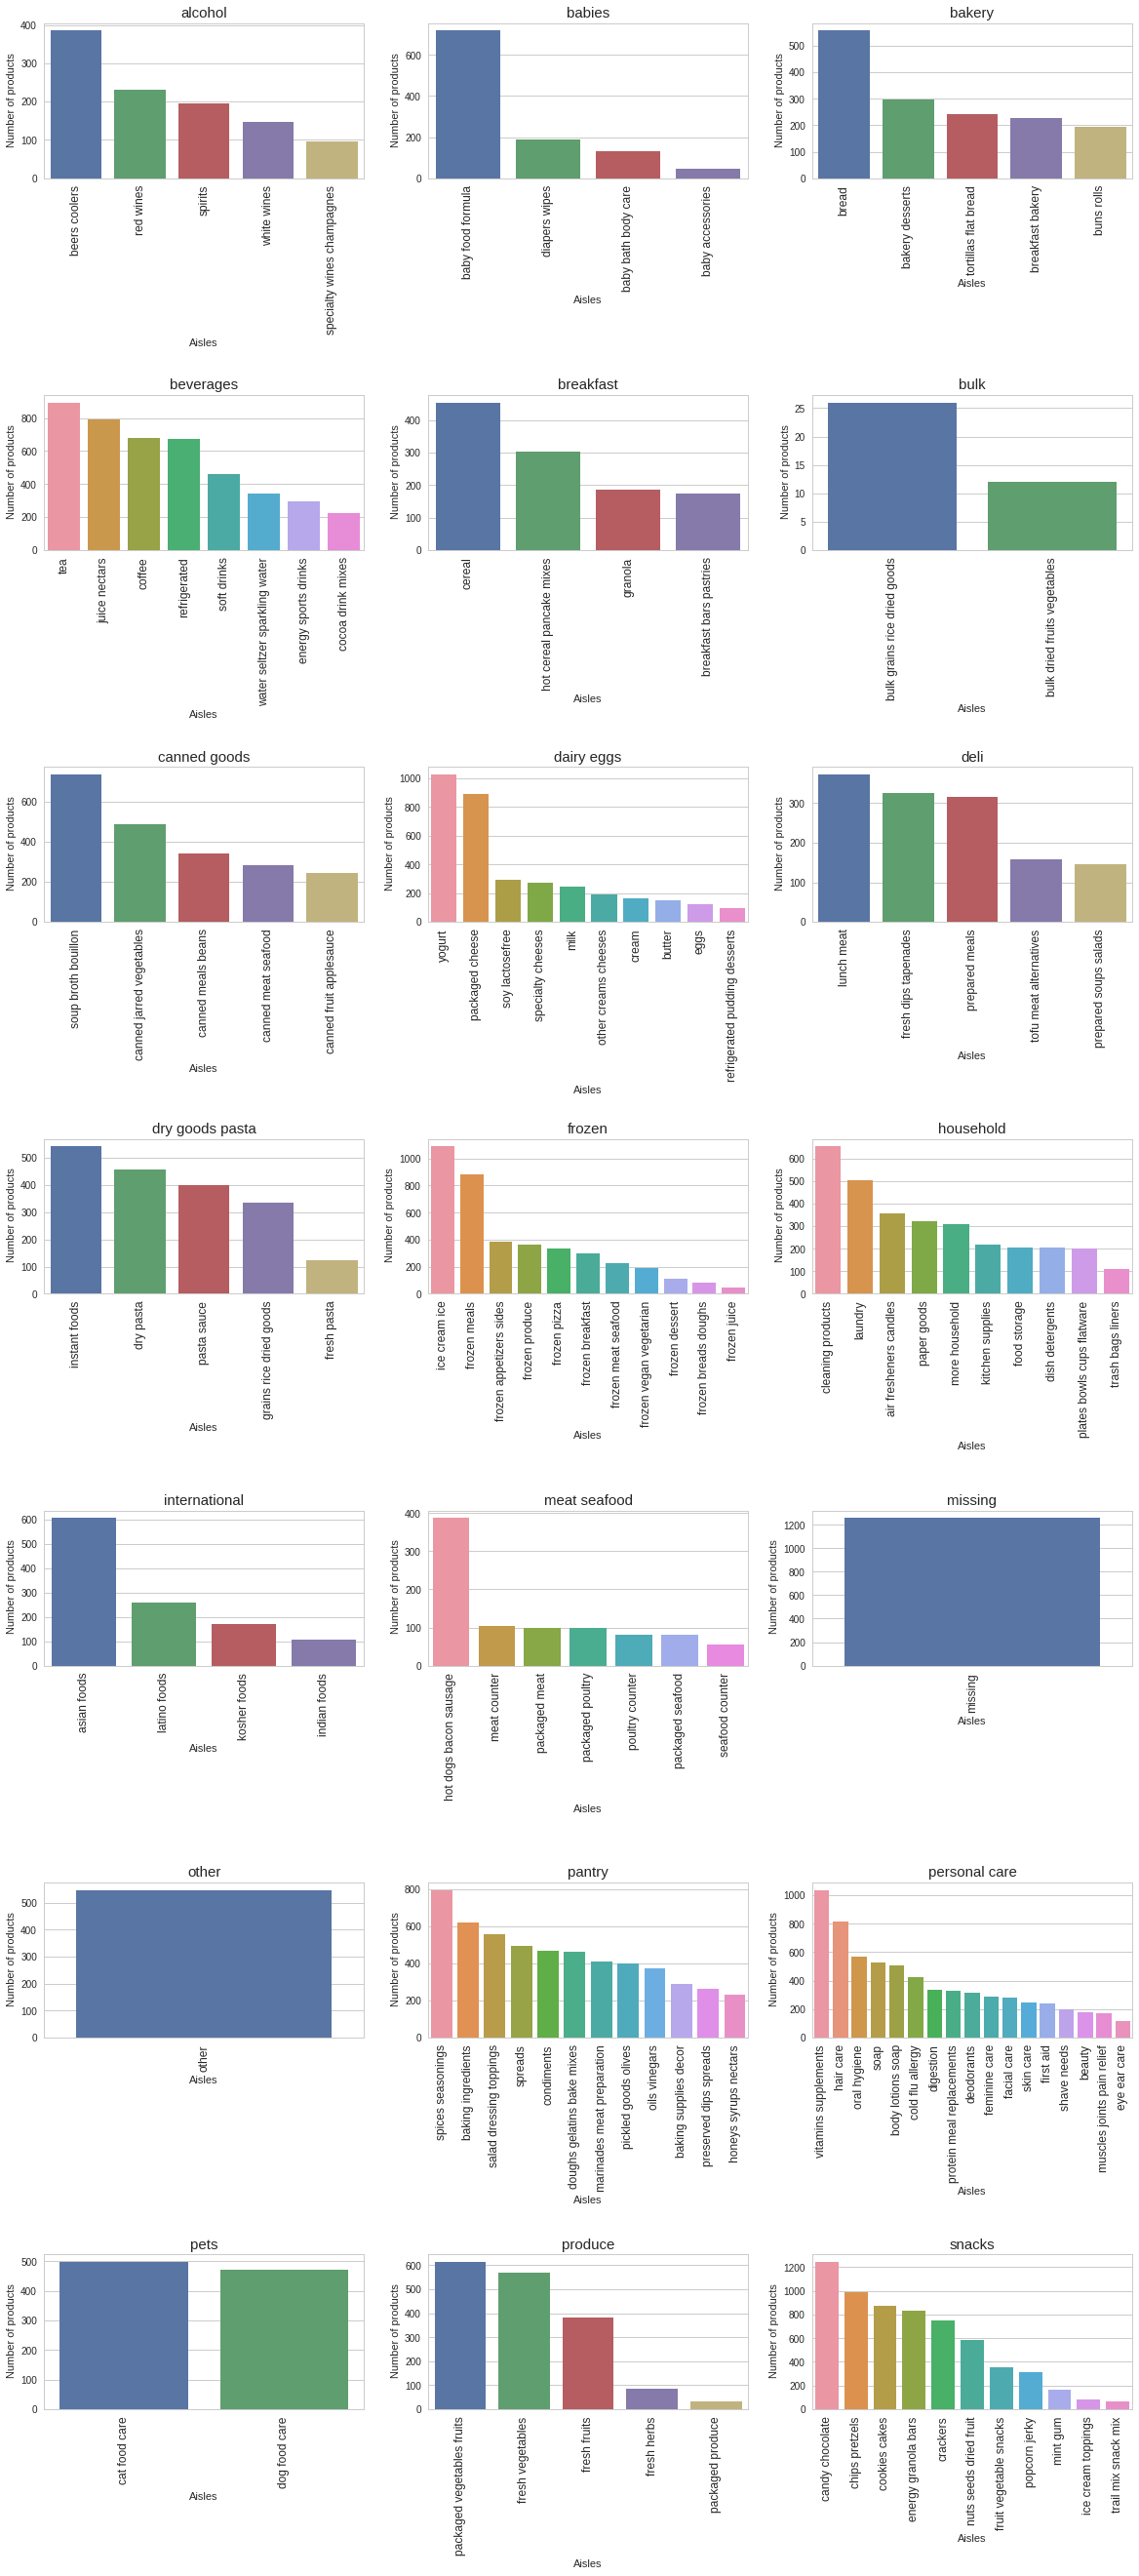

In [33]:
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### Most important Aisles over all Departments (by number of Products)

In [34]:
grouped = items.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025318
18,candy chocolate,1246,0.025076
71,ice cream ice,1091,0.021957
130,vitamins supplements,1038,0.020890
133,yogurt,1026,0.020649
25,chips pretzels,989,0.019904
125,tea,894,0.017992
93,packaged cheese,891,0.017932
59,frozen meals,880,0.017711
31,cookies cakes,874,0.017590


### Best Selling Departments (number of Orders)

In [43]:
users_flow = orders_df[['user_id', 'order_id']].merge(op_all_df[['order_id', 'product_id']],
                                          how='inner', on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

In [48]:
grouped = users_flow.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,9888378,0.292390
7,dairy eggs,5631067,0.166505
20,snacks,3006412,0.088897
3,beverages,2804175,0.082917
10,frozen,2336858,0.069099
16,pantry,1956819,0.057861
2,bakery,1225181,0.036227
6,canned goods,1114857,0.032965
8,deli,1095540,0.032394
9,dry goods pasta,905340,0.026770


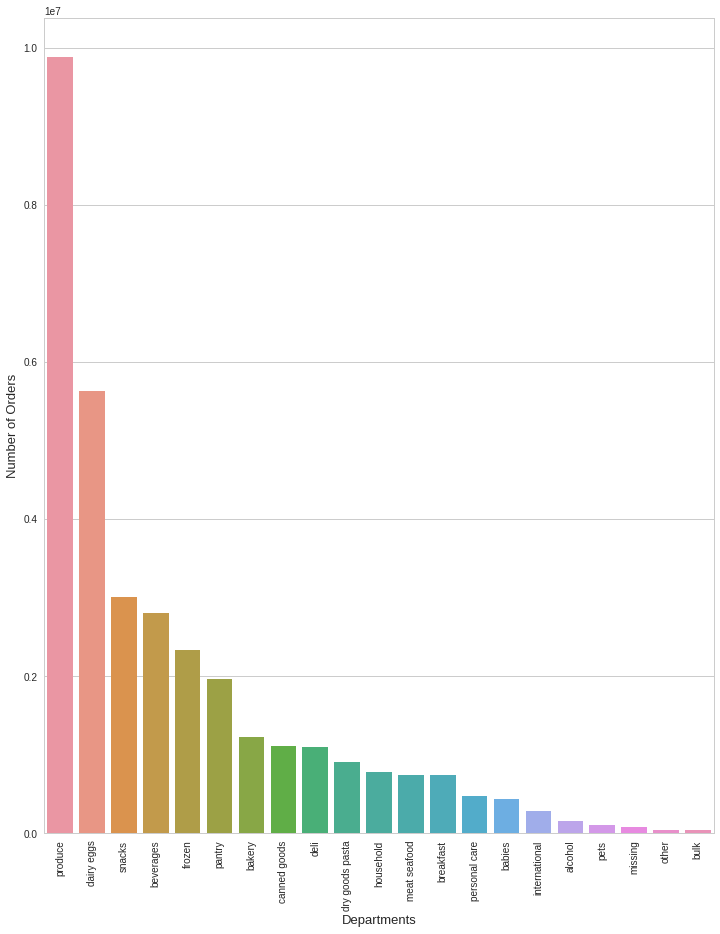

In [49]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

### Best Selling Aisles in each Department (number of Orders)

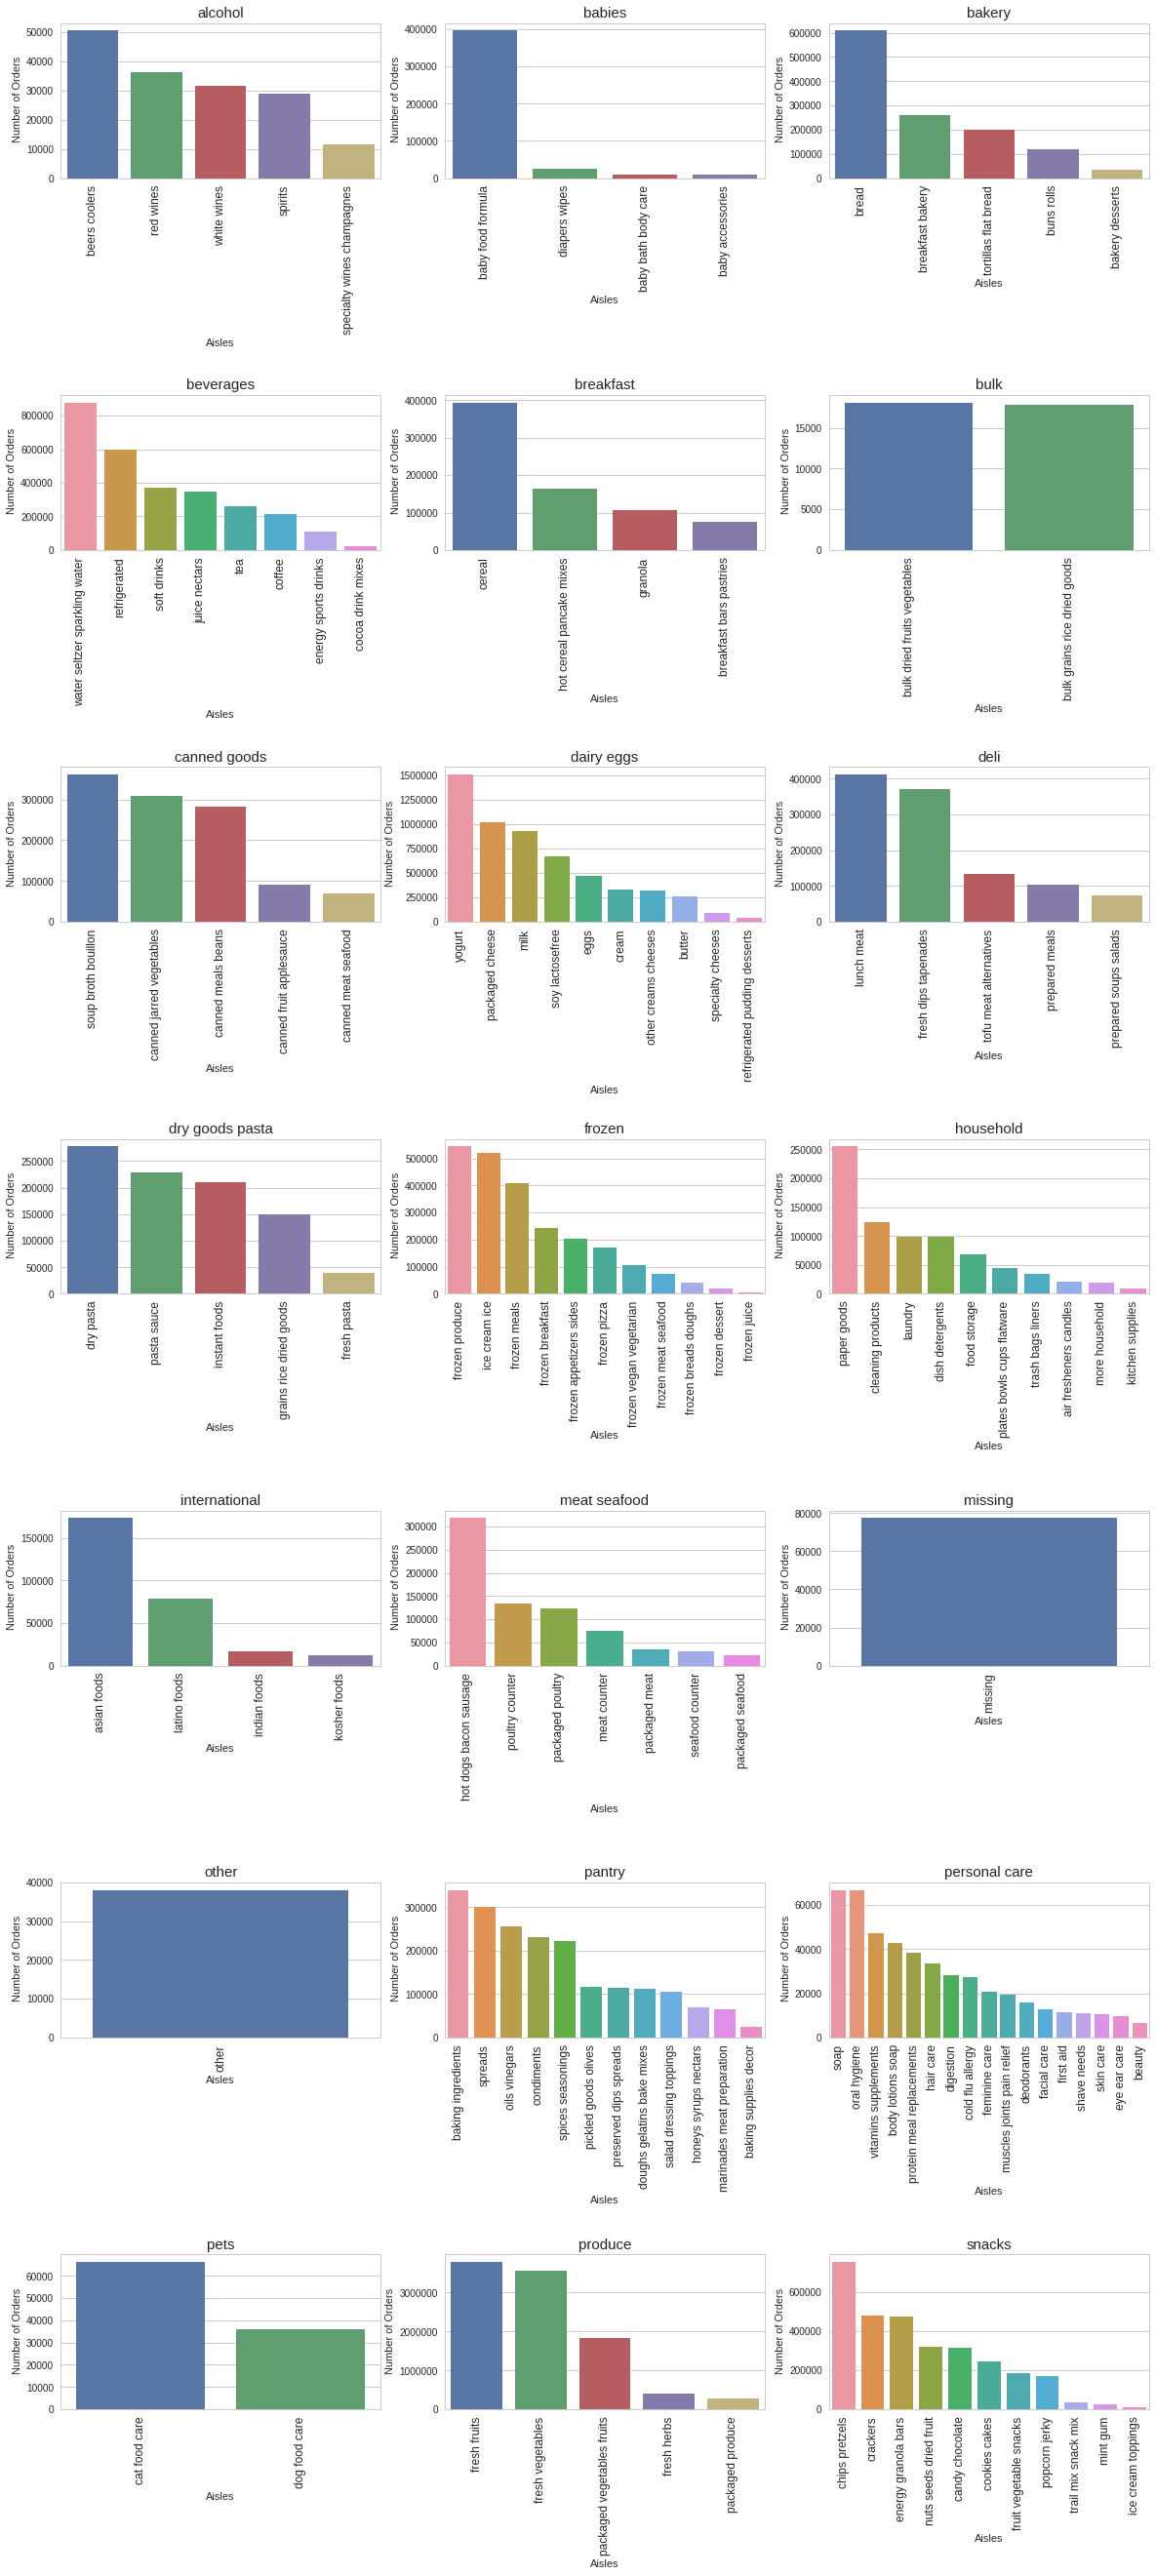

In [50]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### Best Selling Aisles over all Departments.

In [51]:
grouped = users_flow.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
50,fresh fruits,3792661,0.112146
53,fresh vegetables,3568630,0.105521
98,packaged vegetables fruits,1843806,0.054520
133,yogurt,1507583,0.044578
93,packaged cheese,1021462,0.030204
83,milk,923659,0.027312
131,water seltzer sparkling water,878150,0.025966
25,chips pretzels,753739,0.022287
119,soy lactosefree,664493,0.019648
11,bread,608469,0.017992


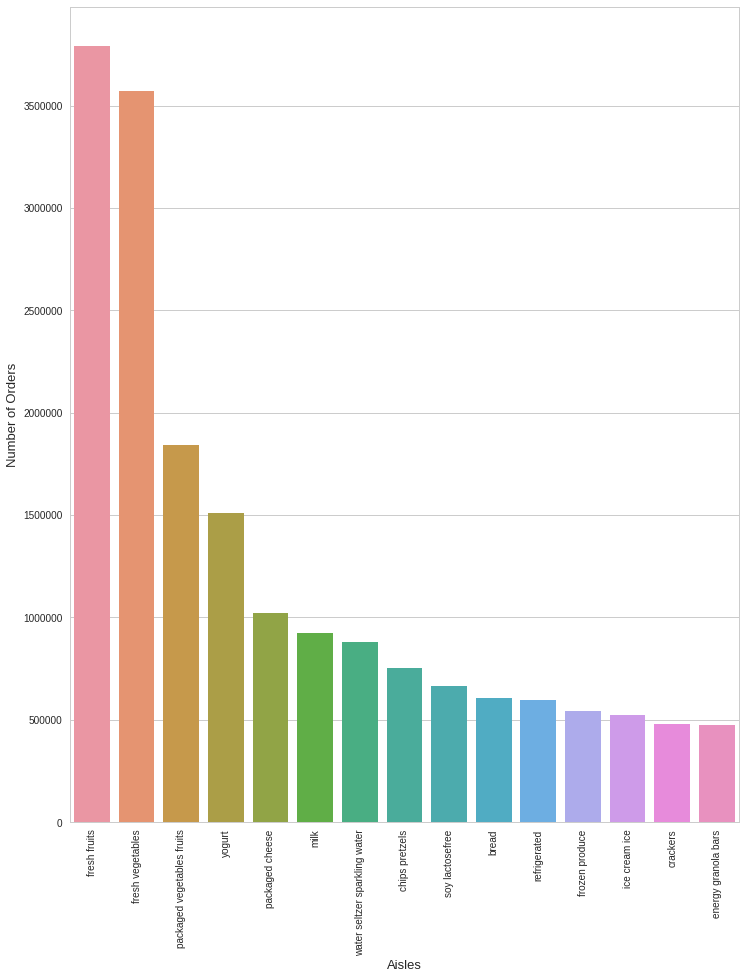

In [52]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()